## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold

from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('../data/tod-on-main.csv')

In [3]:
y1 = df["n_movers_out"]
y2 = df["n_movers_out_Lowincome"]

In [4]:
before_df = df.filter(regex=r'^(Before)', axis=1)
after_df = df.filter(regex=r'^(After)', axis=1)

In [5]:
def calculating_average_bedrooms(df, before = True):
    word = "Before" if before else "After"
    null_rows = df[df[f"{word} Average number of bedrooms per dwelling"].isnull()]
    weighted_sum = (0.5 * null_rows[f"{word} 0 to 1 bedroom"] + 2 * null_rows[f"{word} 2 bedrooms"] + 3 * null_rows[f"{word} 3 bedrooms"] + 4.5 * null_rows[f"{word} 4 or more bedrooms"])
    total = (null_rows[[f"{word} 0 to 1 bedroom", f"{word} 2 bedrooms", f"{word} 3 bedrooms", f"{word} 4 or more bedrooms"]].sum(axis=1))
    null_rows[f"{word} Average number of bedrooms per dwelling"] = weighted_sum / total
    df.loc[null_rows.index, f"{word} Average number of bedrooms per dwelling"] = null_rows[f"{word} Average number of bedrooms per dwelling"]

In [6]:
calculating_average_bedrooms(before_df)
calculating_average_bedrooms(after_df, False)

/var/folders/qd/w0jg42cx76sc6s81d9zfb7t80000gn/T/ipykernel_40568/1411688805.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_rows[f"{word} Average number of bedrooms per dwelling"] = weighted_sum / total
/var/folders/qd/w0jg42cx76sc6s81d9zfb7t80000gn/T/ipykernel_40568/1411688805.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[null_rows.index, f"{word} Average number of bedrooms per dwelling"] = null_rows[f"{word} Average number of bedrooms per dwelling"]
/var/folders/qd/w0jg42cx76sc6s81d9zfb7t80000gn/T/ipykernel_40568/1411688805.py:6: SettingWi

In [7]:
# Drop all the individual bedroom columns

cols_to_drop = before_df.filter(regex='bedrooms?$', axis=1).columns
before_df = before_df.drop(columns = cols_to_drop)
cols_to_drop = after_df.filter(regex='bedrooms?$', axis=1).columns
after_df = after_df.drop(columns = cols_to_drop)

In [8]:
# Removing values that either introduce collinearity or have many missing values

before_df = before_df.drop(["Before Apartment", "Before Other dwelling", "Before Other single-attached house"], axis=1)
after_df = after_df.drop(["After Other dwelling", "After Other attached dwelling", "After Other single-attached house"], axis=1)

<hr style="border:5px solid black">

## Dwelling Characteristics Before and After($X_{D, t=A}$ and $X_{D, t=B}$)

### Basic Information

In [9]:
print("Shape is", before_df.shape)
print(before_df.info())

Shape is (70, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 13 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Before Population Density per square kilometre               70 non-null     float64
 1   Before Dwellings                                             42 non-null     float64
 2   Before Total Occupied Private Dwellings                      70 non-null     float64
 3   Before Single-detached house                                 70 non-null     float64
 4   Before Semi-detached house                                   68 non-null     float64
 5   Before Row house                                             68 non-null     float64
 6   Before Apartment, duplex                                     68 non-null     float64
 7   Before Apartment, building that has fewer than five storeys  67 

In [10]:
print("Shape is", after_df.shape)
print(after_df.info())

Shape is (70, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 13 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   After Population Density per square kilometre               70 non-null     float64
 1   After Dwellings                                             67 non-null     float64
 2   After Total Occupied Private Dwellings                      70 non-null     float64
 3   After Single-detached house                                 70 non-null     float64
 4   After Semi-detached house                                   69 non-null     float64
 5   After Row house                                             69 non-null     float64
 6   After Apartment, duplex                                     69 non-null     float64
 7   After Apartment, building that has fewer than five storeys  69 non-null  

### Descriptive Statistics

In [11]:
before_df.describe()

,Before Population Density per square kilometre,Before Dwellings,Before Total Occupied Private Dwellings,Before Single-detached house,Before Semi-detached house,Before Row house,"Before Apartment, duplex","Before Apartment, building that has fewer than five storeys","Before Apartment, building that has five or more storeys",Before Movable dwelling,Before Average number of bedrooms per dwelling,Before Owned,Before Rented
count,70.000000,42.000000,70.000000,70.000000,68.000000,68.000000,68.000000,67.000000,69.000000,70.000000,67.000000,70.000000,70.000000
mean,57324.865634,3098.206985,2377.092768,631.330071,106.456011,122.830811,99.314573,699.484049,730.189949,4.303426,11.505299,1197.312769,1158.123773
std,113216.390124,3194.219870,2443.470807,475.698510,289.957670,116.308517,149.638822,1096.595198,1913.353421,12.835005,13.758891,996.888472,1545.427366
min,11.416007,25.342501,23.201693,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.165434,19.543635,0.000000
25%,1466.122390,1312.711342,753.392018,291.053291,11.674445,46.985050,9.894447,85.638281,0.285230,0.000000,1.787984,497.338881,152.410299
50%,12583.949928,2102.862406,1651.476544,507.219473,36.670702,83.111550,30.451624,242.994205,70.426756,0.000000,3.774275,1027.032961,495.574639
75%,49266.737562,3958.129184,2363.522913,913.379267,77.453149,171.459792,129.620319,652.988816,269.750273,1.772189,19.921261,1473.078837,1458.260640
max,646168.395259,15586.510605,13367.434463,2680.843792,2184.042565,530.012660,598.664877,4987.192384,12328.098726,91.828328,76.046415,6500.350673,6299.885511


In [12]:
after_df.describe()

,After Population Density per square kilometre,After Dwellings,After Total Occupied Private Dwellings,After Single-detached house,After Semi-detached house,After Row house,"After Apartment, duplex","After Apartment, building that has fewer than five storeys","After Apartment, building that has five or more storeys",After Movable dwelling,After Average number of bedrooms per dwelling,After Owned,After Rented
count,70.000000,67.000000,70.000000,70.000000,69.000000,69.000000,69.000000,69.000000,70.000000,70.000000,69.000000,70.000000,70.000000
mean,83624.500274,3454.156110,3071.057221,549.088128,100.673967,165.759904,133.773431,885.814569,1241.478952,1.975930,8.349612,1566.607717,1505.943250
std,142428.398970,3622.260092,3172.590281,395.692437,186.987633,147.981826,178.908345,1273.010765,2850.124071,7.340025,9.469632,1266.862745,2034.268261
min,43.457565,120.044240,114.496750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.847467,86.953966,7.058546
25%,14117.821398,1364.931211,1330.202504,199.576745,11.158394,63.859120,22.881912,102.108253,1.012046,0.000000,2.093622,916.411274,243.948163
50%,36723.365589,2047.696021,1897.681001,487.073987,37.753862,138.407120,55.823227,412.285193,175.389237,0.000000,3.370126,1214.996519,696.174944
75%,72629.650488,4011.115867,3434.903365,772.408622,108.807448,202.678166,166.115243,885.858249,801.944525,0.000000,13.034814,1790.574435,1758.727080
max,908077.330189,20128.428244,18201.958223,1806.899375,1049.457765,729.977453,836.292051,6027.096504,17201.085022,49.084532,37.757402,8065.027575,10186.572329


### Correlations

In [13]:
temp_before_df = before_df.copy()
temp_after_df = after_df.copy()

In [14]:
temp_before_df["n_movers_out"] = y1
temp_before_df["n_movers_out_Lowincome"] = y2
temp_after_df["n_movers_out"] = y1
temp_after_df["n_movers_out_Lowincome"] = y2

In [15]:
b_corr = temp_before_df.corr()
a_corr = temp_after_df.corr()

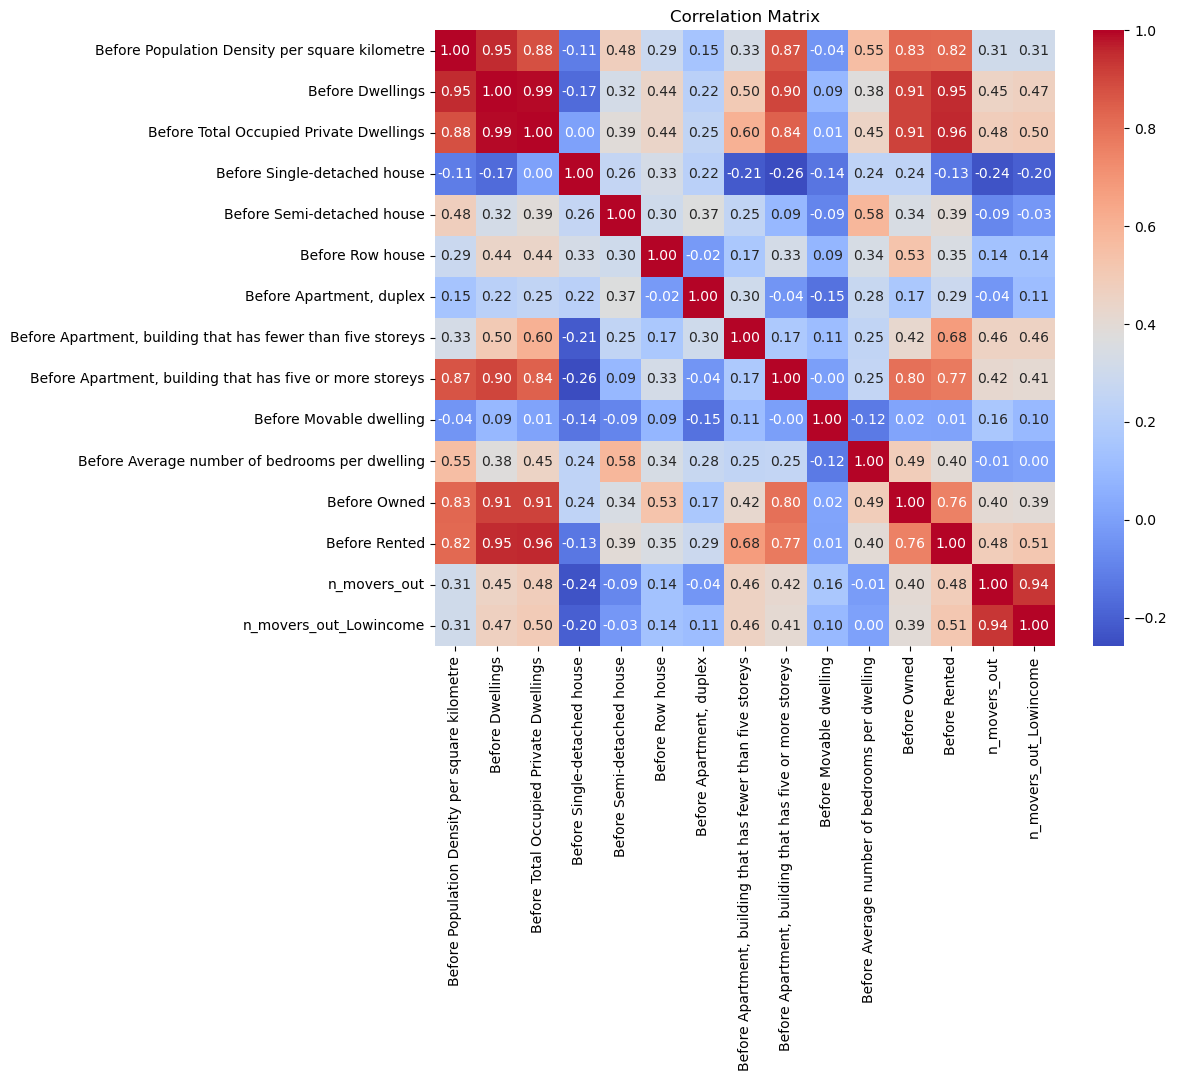

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(b_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

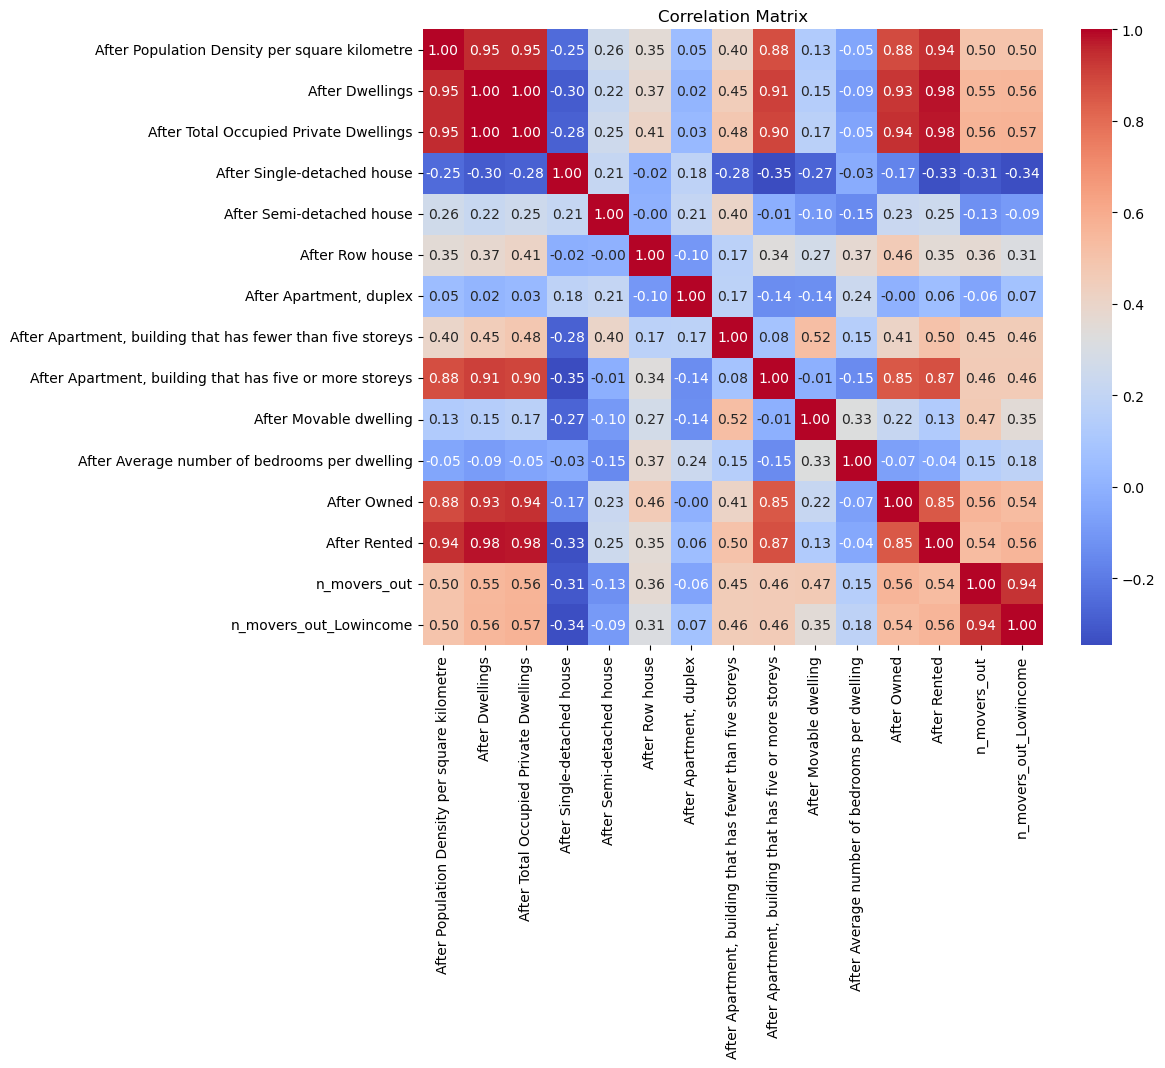

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(a_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Visualizations

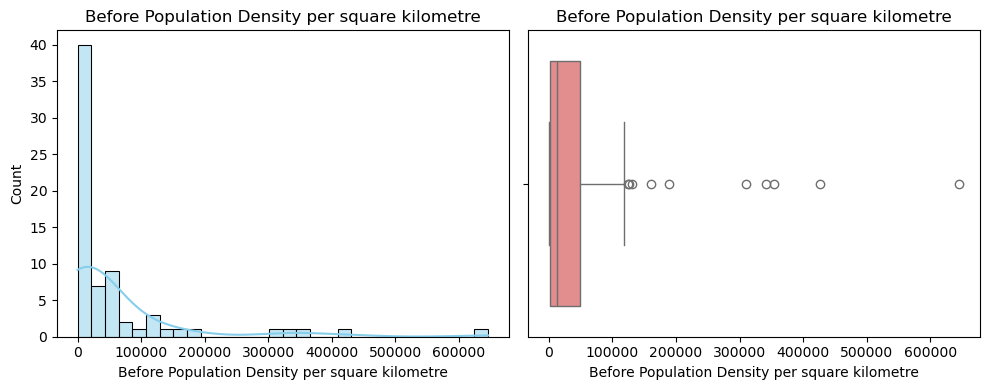

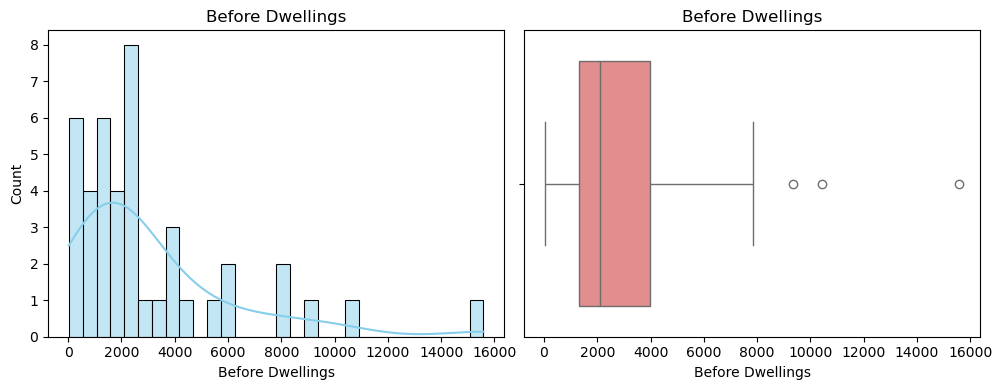

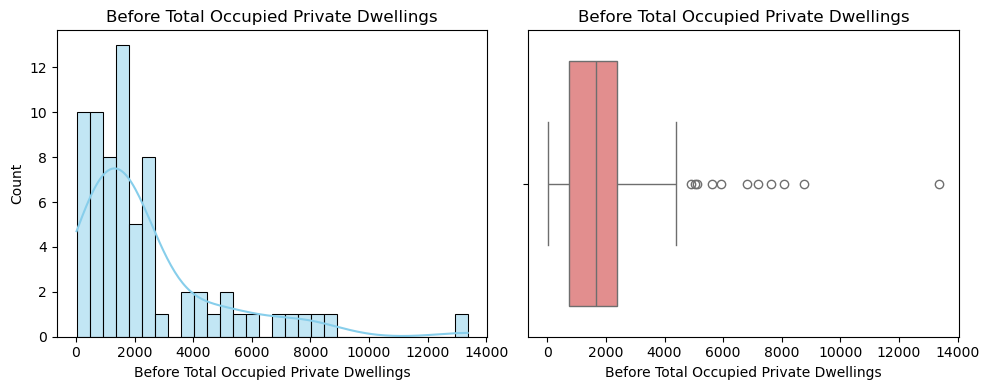

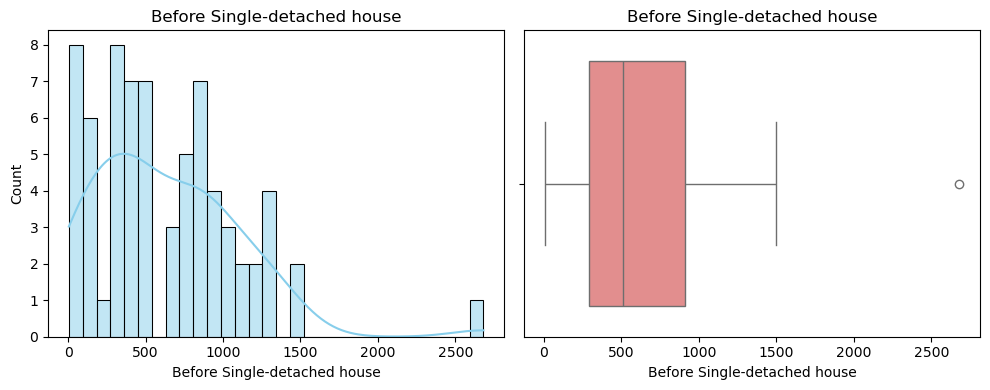

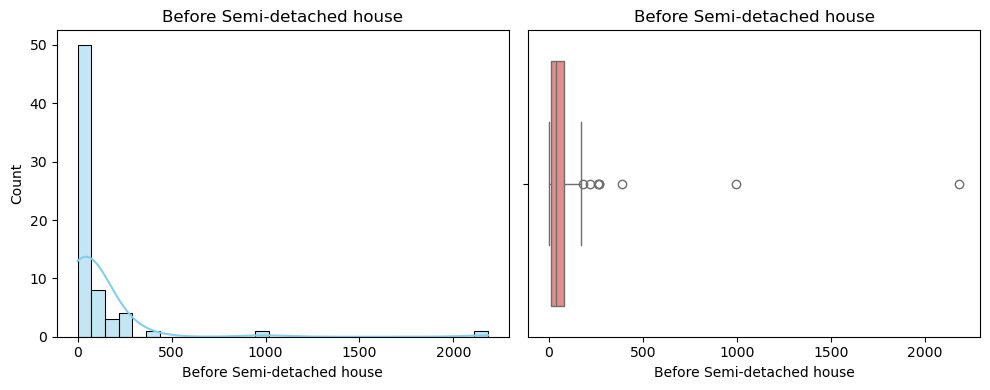

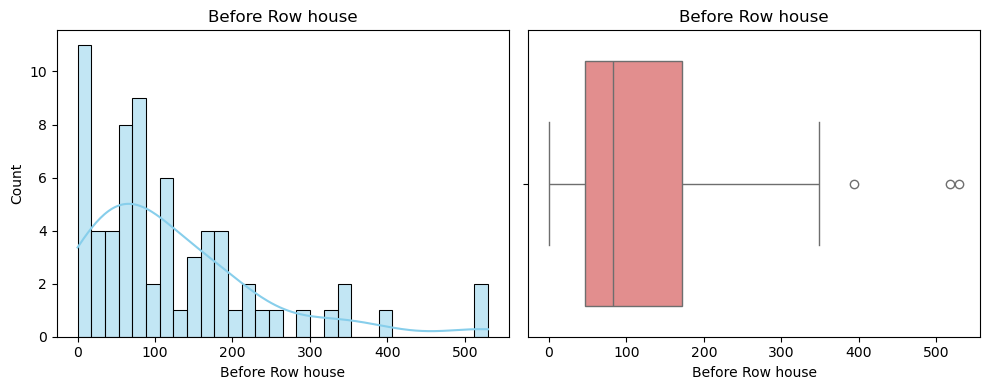

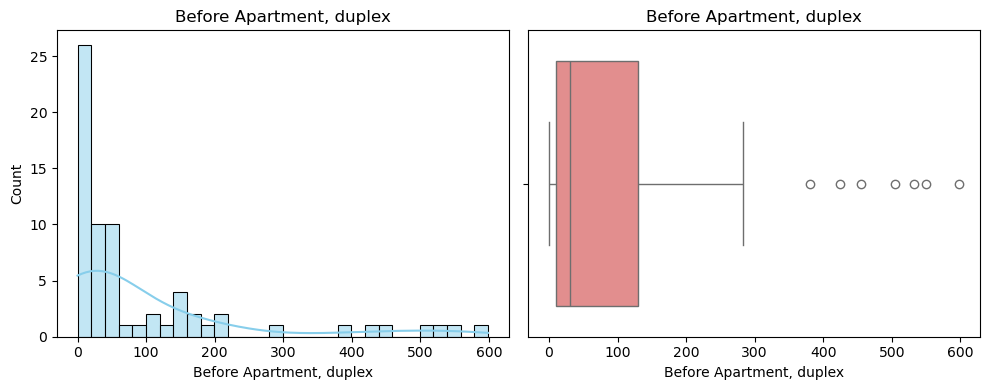

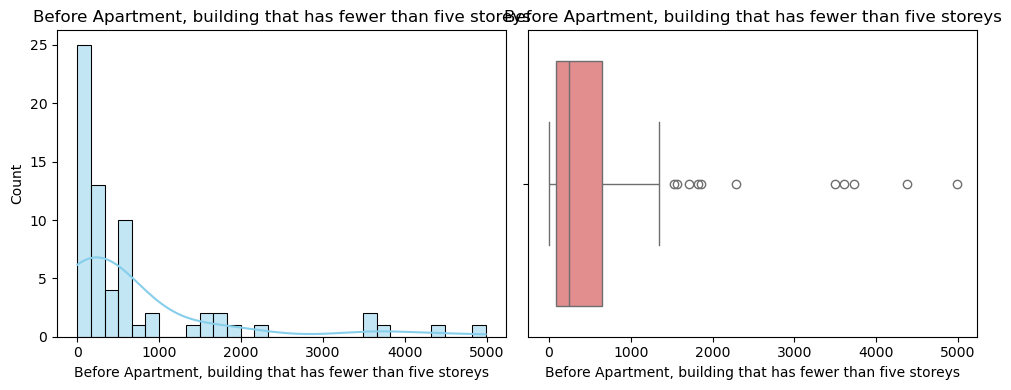

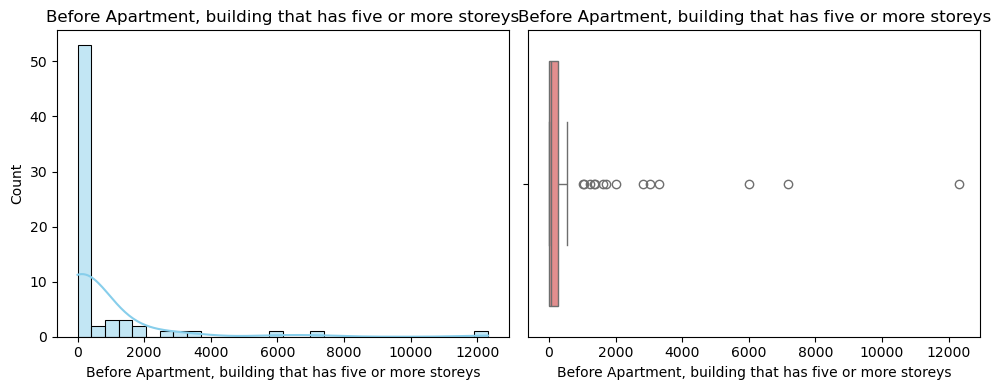

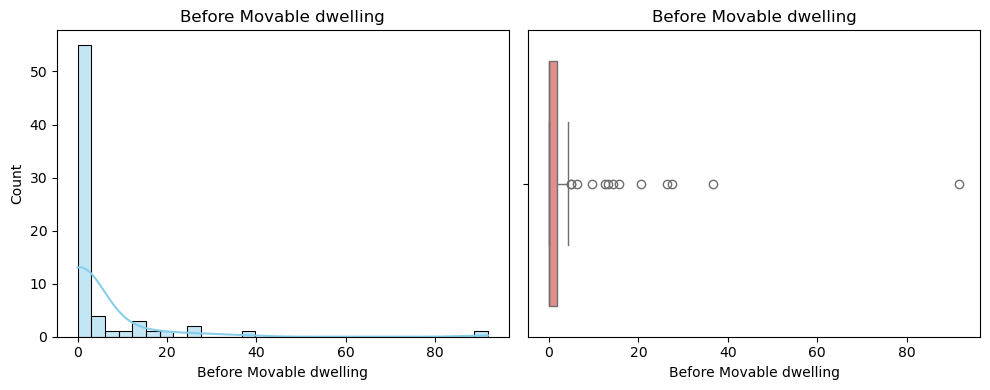

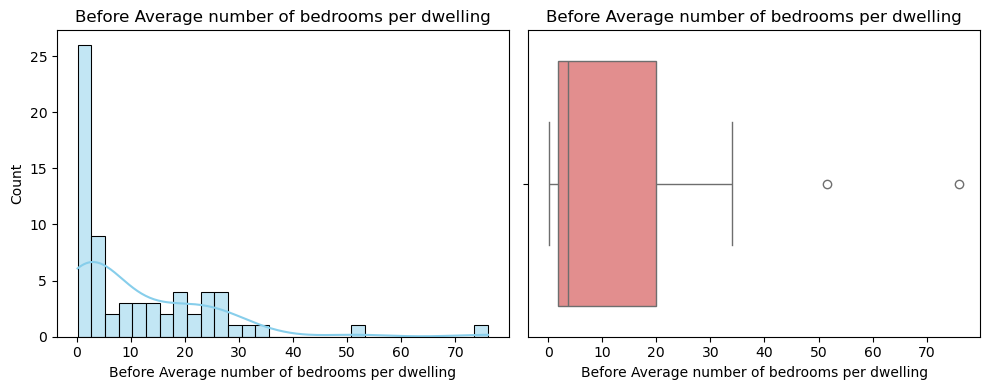

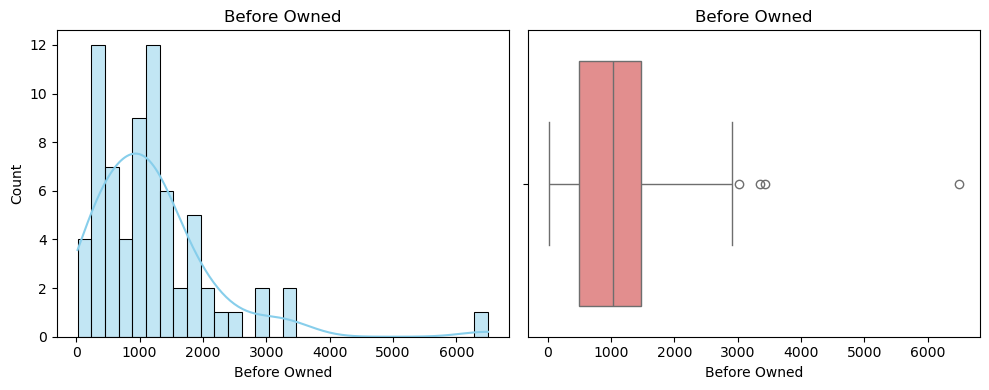

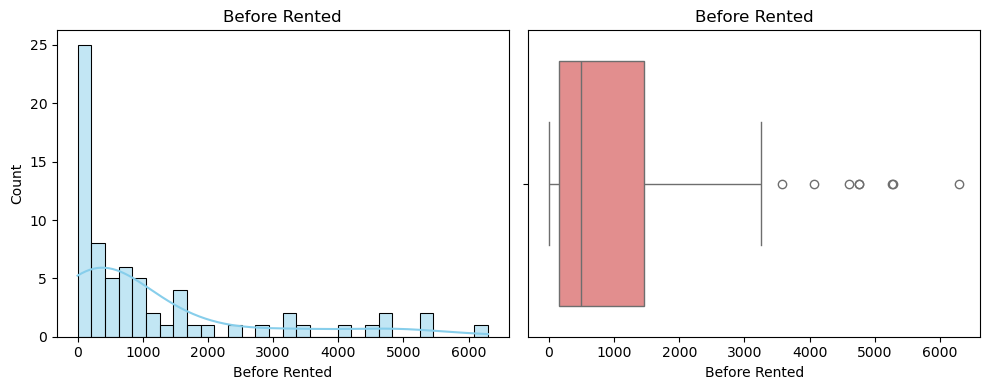

In [18]:
for col in before_df.columns:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(before_df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'{col}')
    plt.xlabel(col)

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=before_df[col], color='lightcoral')
    plt.title(f'{col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()


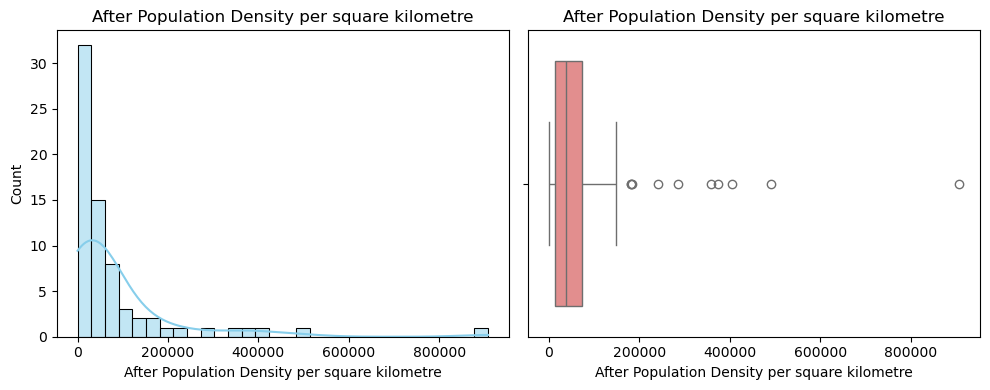

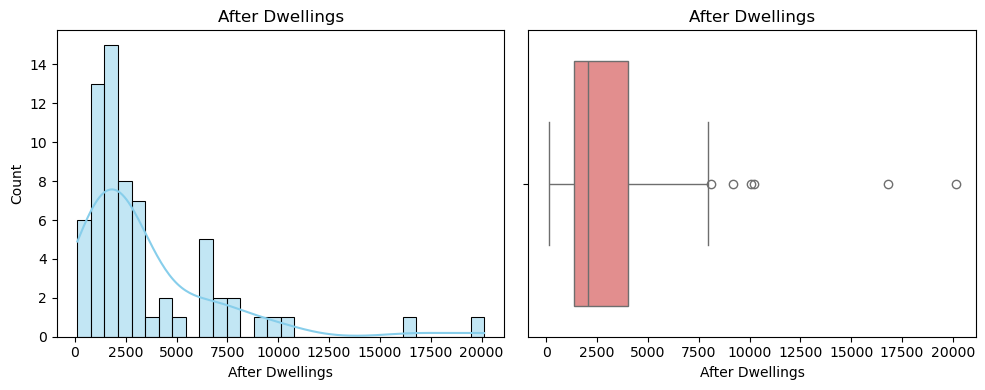

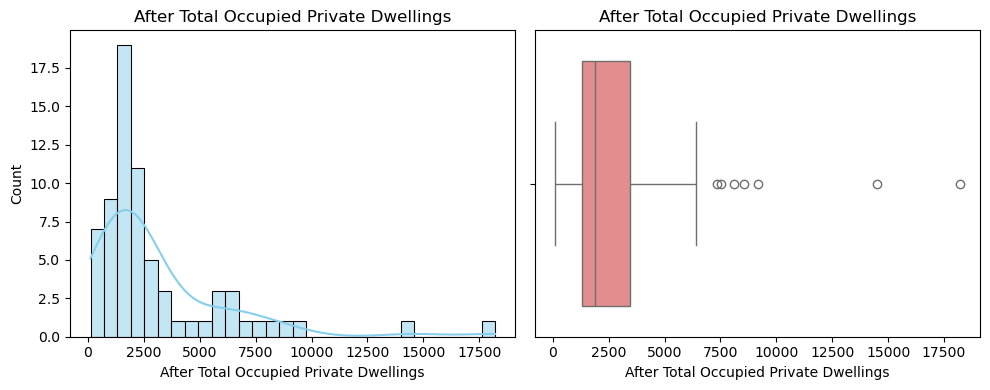

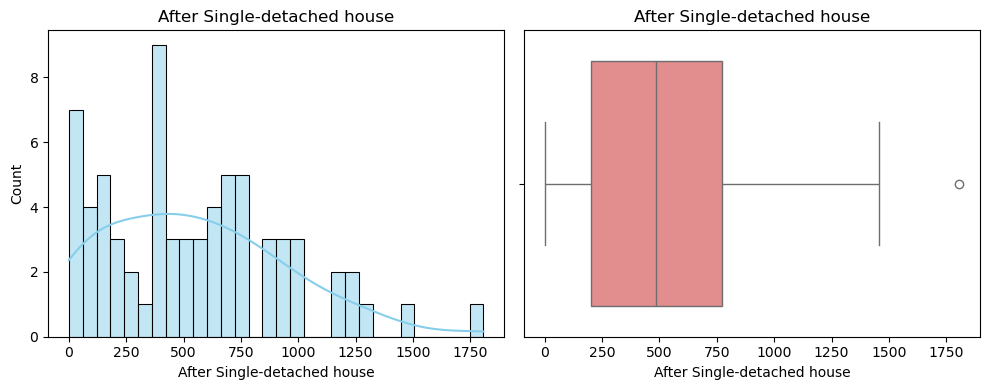

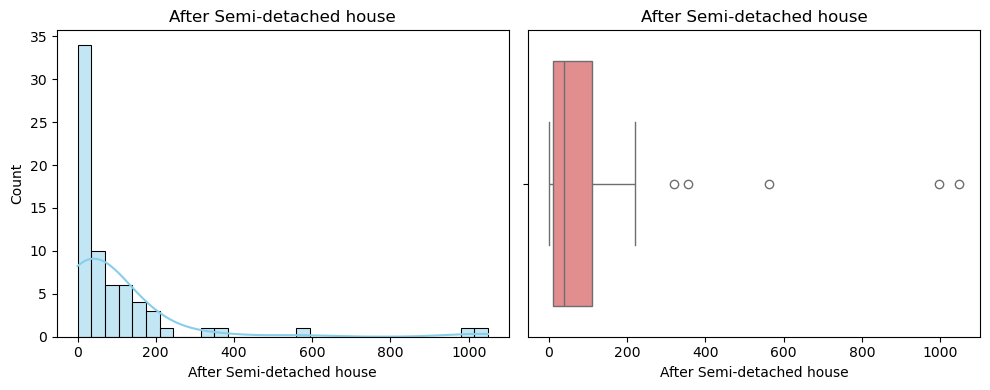

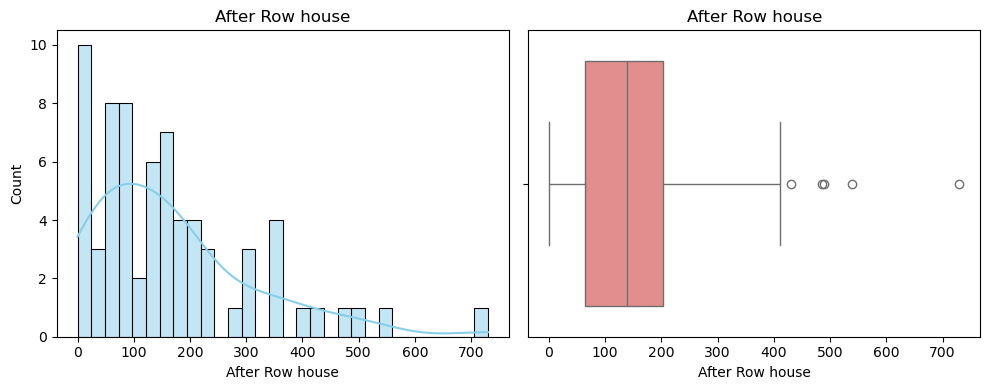

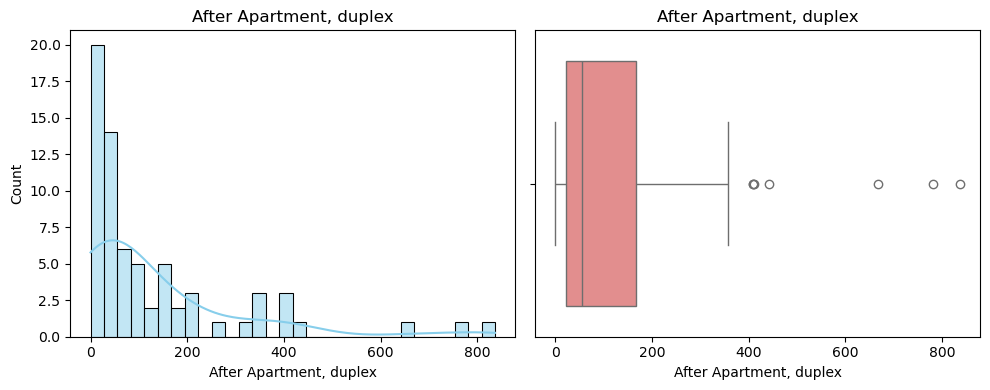

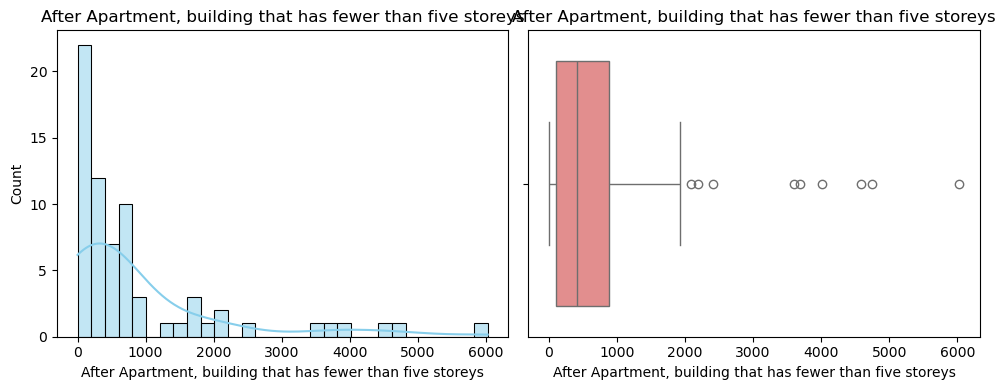

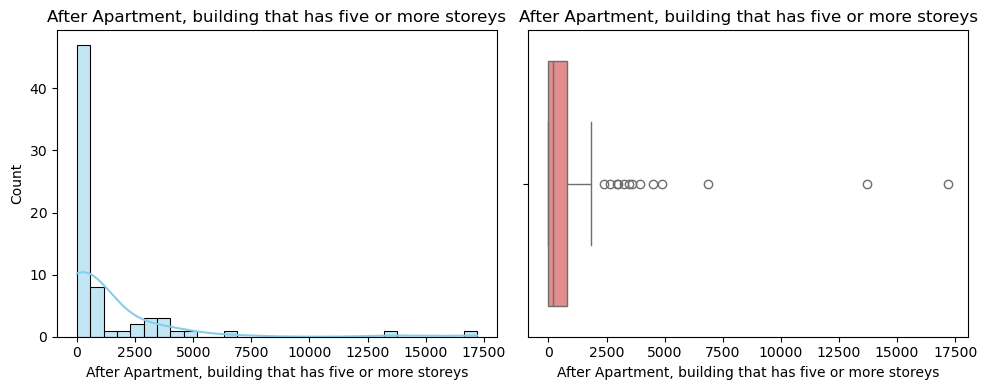

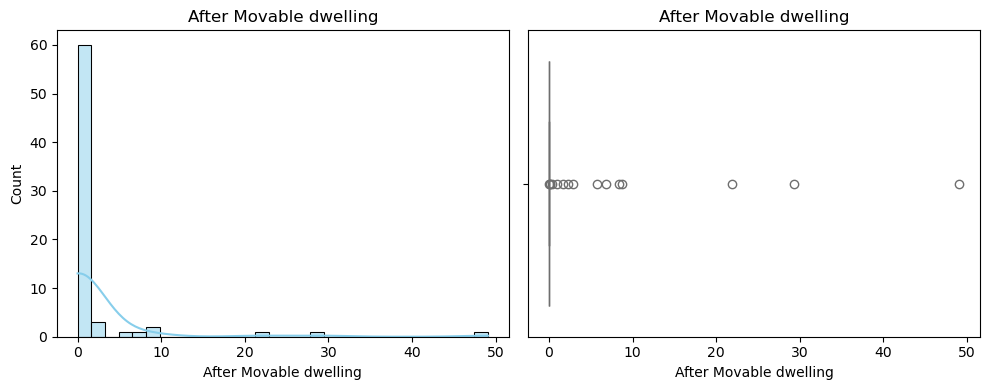

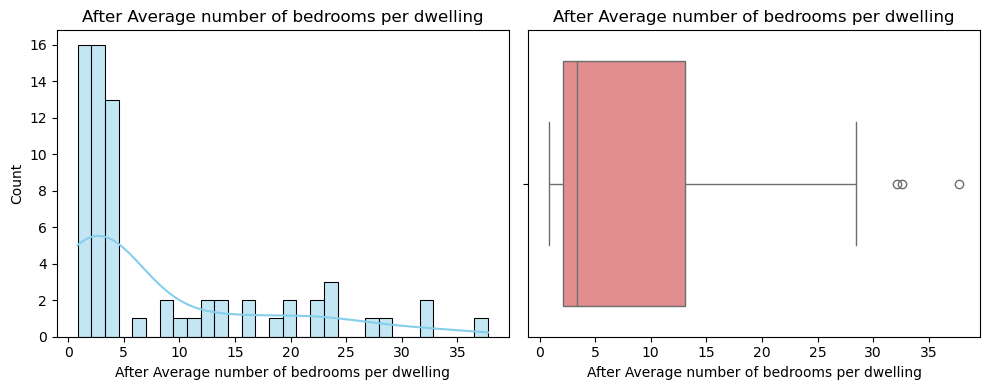

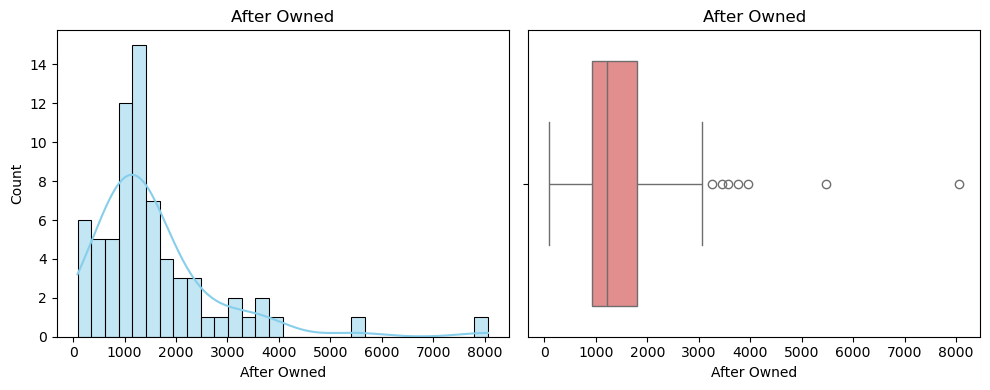

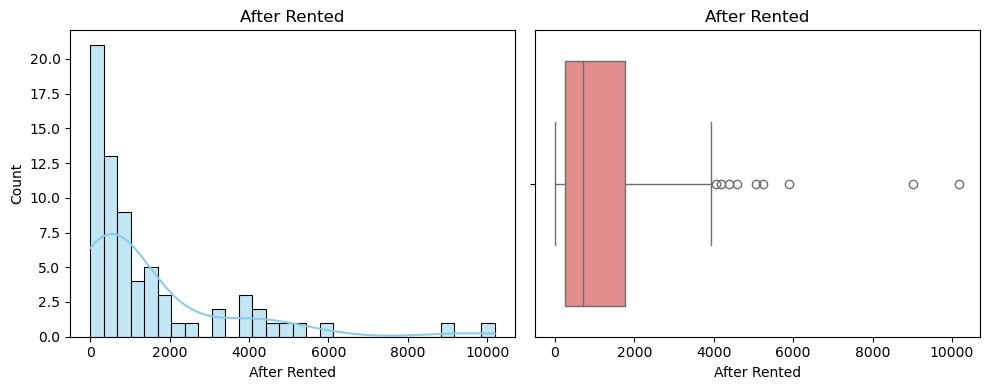

In [19]:
for col in after_df.columns:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(after_df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'{col}')
    plt.xlabel(col)

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=after_df[col], color='lightcoral')
    plt.title(f'{col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()


<hr style="border:5px solid black">

## Change in Dwelling Characteristics ($X_{D, t=B} - X_{D, t=A}$)

In [20]:
before_combied_df = before_df.copy()
after_combined_df = after_df.copy()

In [21]:
before_combied_df.columns = before_combied_df.columns.str.replace(r'^\w+\s+', 'Change ', regex=True)
after_combined_df.columns = after_combined_df.columns.str.replace(r'^\w+\s+', 'Change ', regex=True)

In [22]:
change_df = after_combined_df - before_combied_df

### Basic Information

In [23]:
print("Shape is", change_df.shape)
print(change_df.info())

Shape is (70, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 13 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Change Population Density per square kilometre               70 non-null     float64
 1   Change Dwellings                                             42 non-null     float64
 2   Change Total Occupied Private Dwellings                      70 non-null     float64
 3   Change Single-detached house                                 70 non-null     float64
 4   Change Semi-detached house                                   67 non-null     float64
 5   Change Row house                                             67 non-null     float64
 6   Change Apartment, duplex                                     67 non-null     float64
 7   Change Apartment, building that has fewer than five storeys  67 

### Descriptive Statistics

In [24]:
change_df.describe()

,Change Population Density per square kilometre,Change Dwellings,Change Total Occupied Private Dwellings,Change Single-detached house,Change Semi-detached house,Change Row house,"Change Apartment, duplex","Change Apartment, building that has fewer than five storeys","Change Apartment, building that has five or more storeys",Change Movable dwelling,Change Average number of bedrooms per dwelling,Change Owned,Change Rented
count,70.000000,42.000000,70.000000,70.000000,67.000000,67.000000,67.000000,67.000000,69.000000,70.000000,67.000000,70.000000,70.000000
mean,26299.634640,883.319497,693.964453,-82.241943,-0.833926,52.662304,36.191890,206.766529,526.751092,-2.327495,-2.975906,369.294949,347.819477
std,60371.696622,1336.536040,1270.095669,312.538167,150.808506,102.142136,76.494638,522.908993,1159.337471,13.632734,19.911037,673.221919,763.750245
min,-114328.566760,-134.520004,-3232.366353,-1744.971817,-1134.584800,-182.352904,-124.492084,-297.934437,-562.452948,-91.828328,-74.211854,-2230.835651,-1003.893486
25%,323.224019,101.644461,64.381509,-111.097820,-7.404296,-4.936081,2.233814,-5.296298,0.000000,-0.182522,-17.598195,7.404316,9.543126
50%,12068.849501,308.709050,308.536828,-42.882578,0.732230,14.310004,16.010693,59.605595,31.441484,0.000000,-1.150834,179.664651,150.817015
75%,24253.407984,866.104584,889.228913,2.040854,17.634644,97.721677,45.415716,177.533343,409.726686,0.000000,12.321722,613.583455,470.461598
max,265403.516472,6360.438617,6448.940354,717.692927,298.465238,414.316244,331.402535,2658.230539,6542.339135,28.407071,34.646123,2555.753834,4257.012461


### Correlations

In [25]:
temp_change_df = change_df.copy()

In [26]:
temp_change_df["n_movers_out"] = y1
temp_change_df["n_movers_out_Lowincome"] = y2

In [27]:
c_corr = temp_change_df.corr()

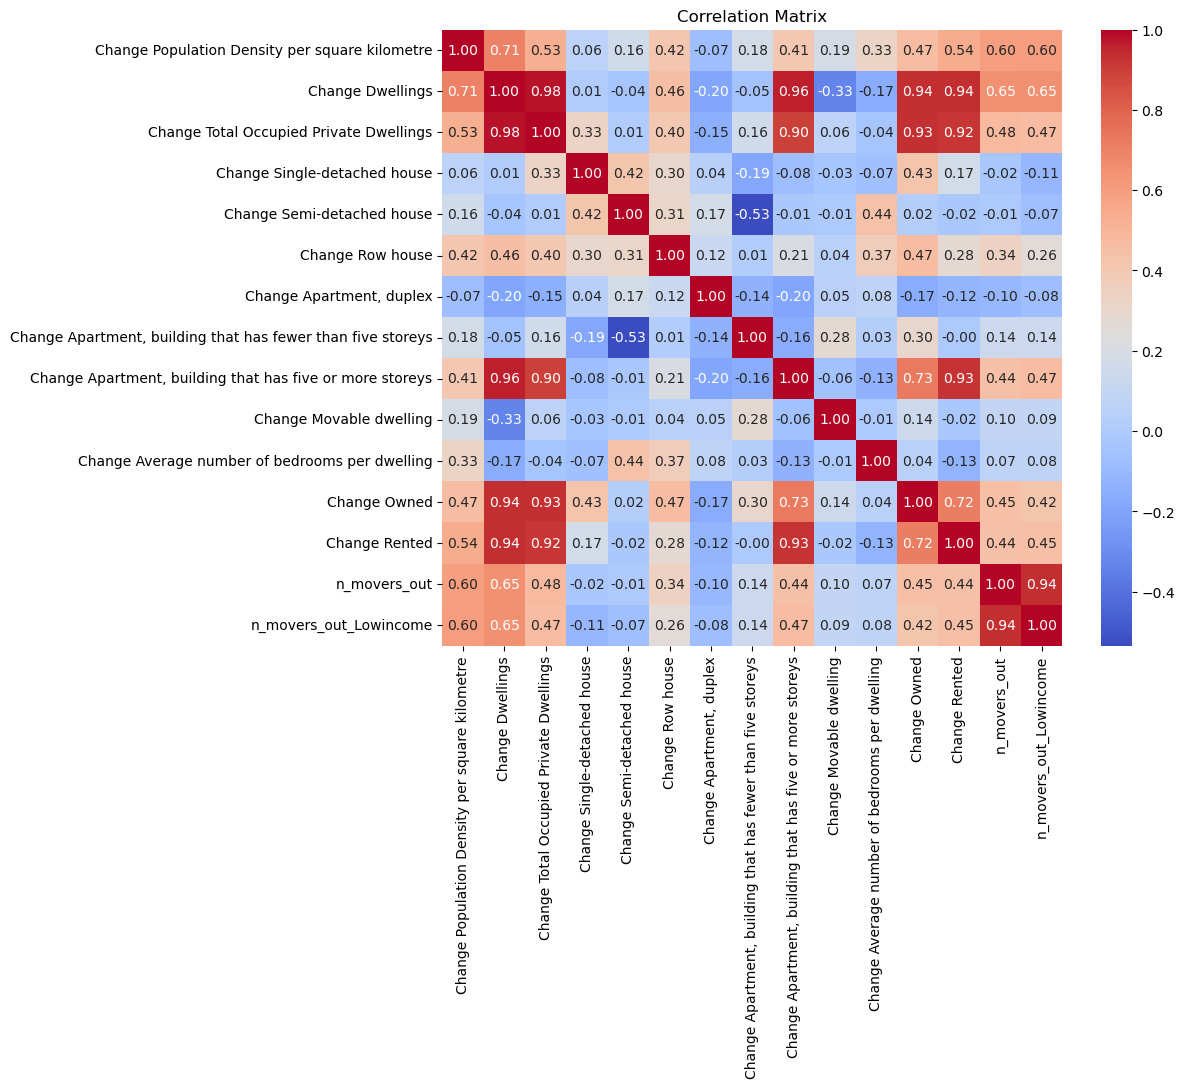

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(c_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Visualizations

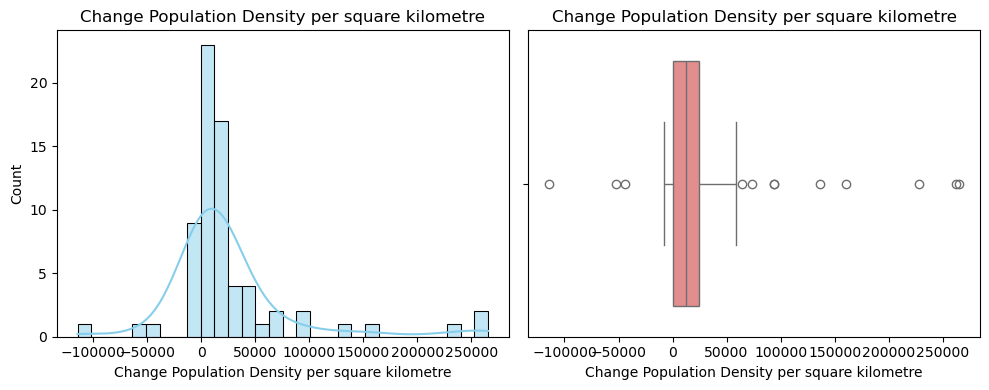

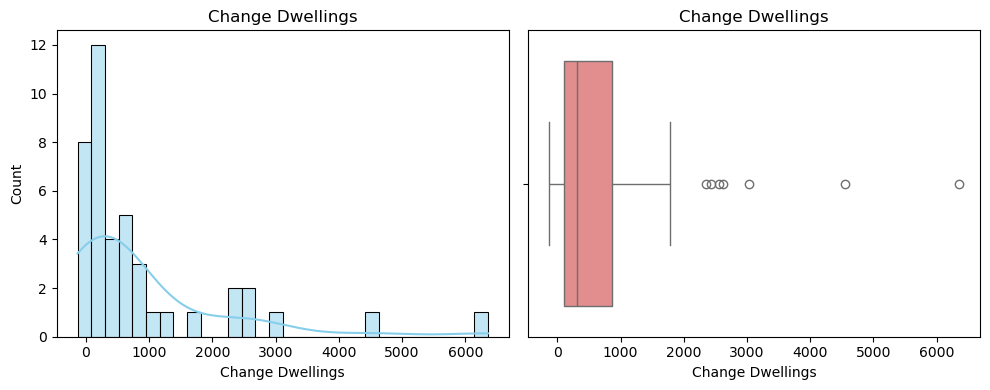

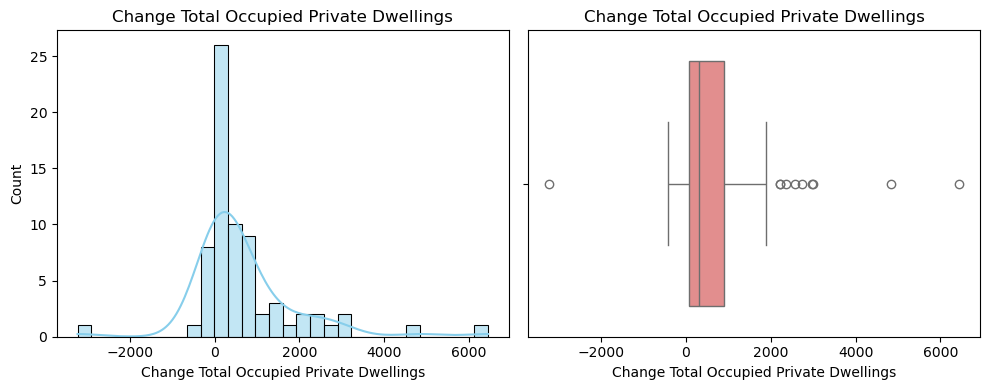

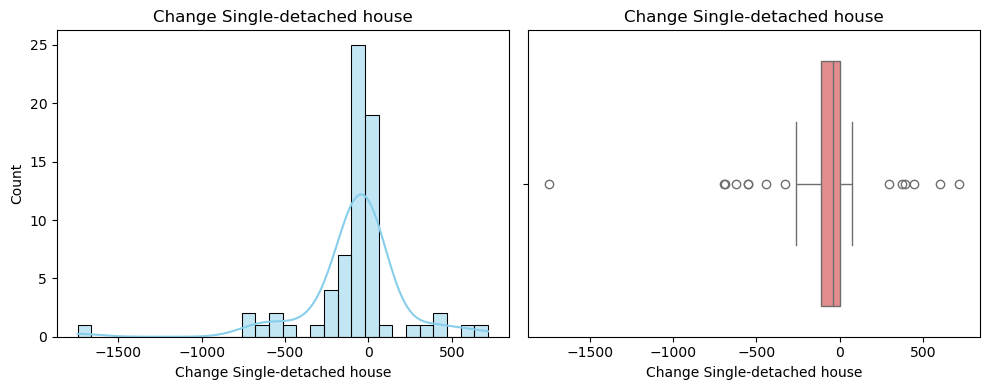

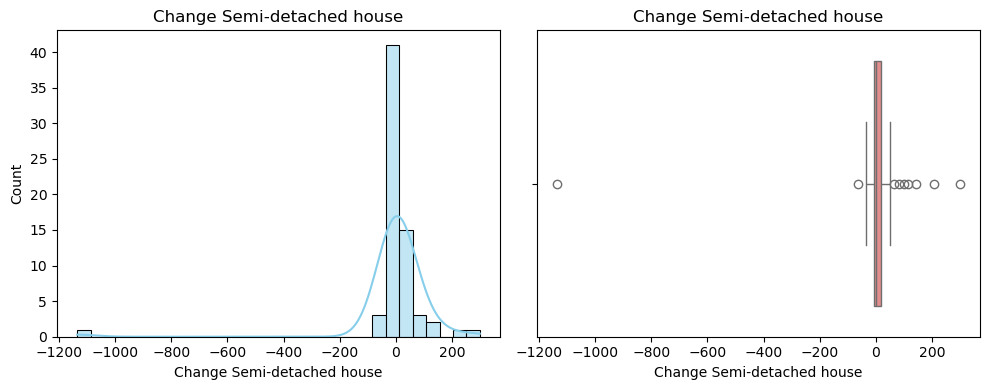

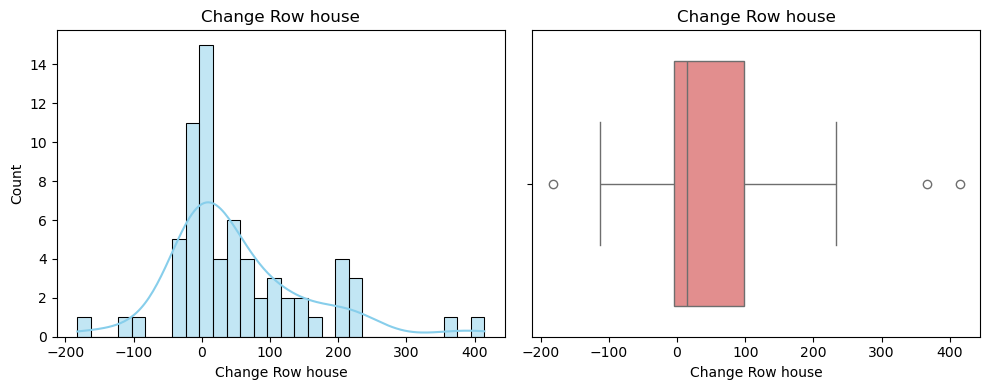

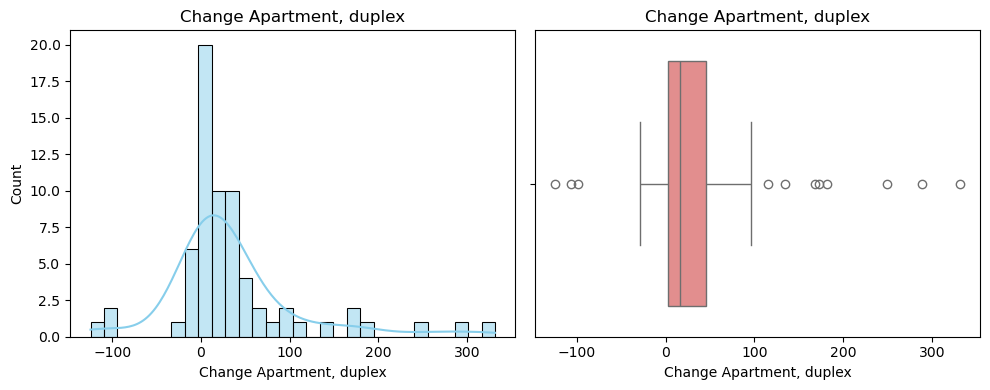

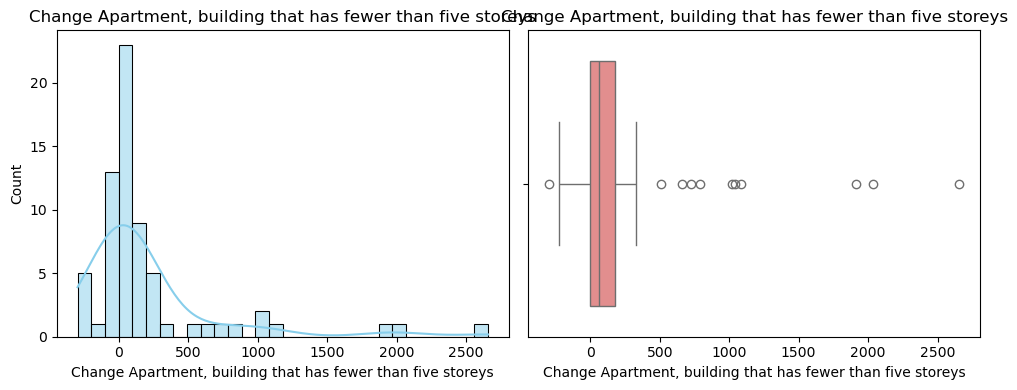

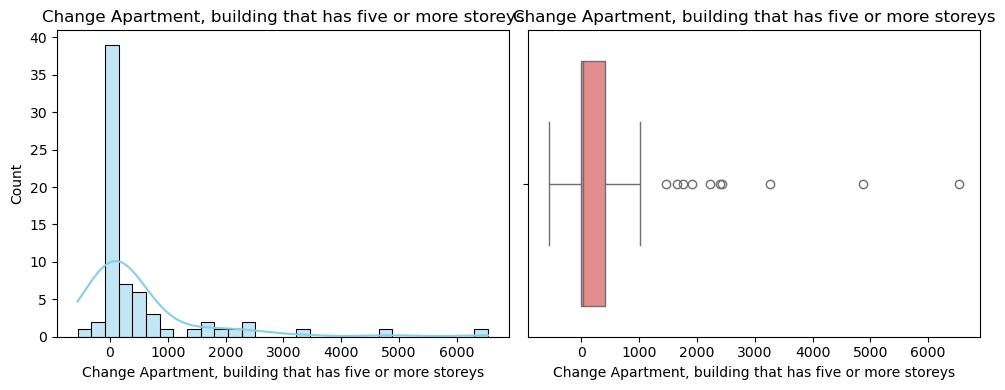

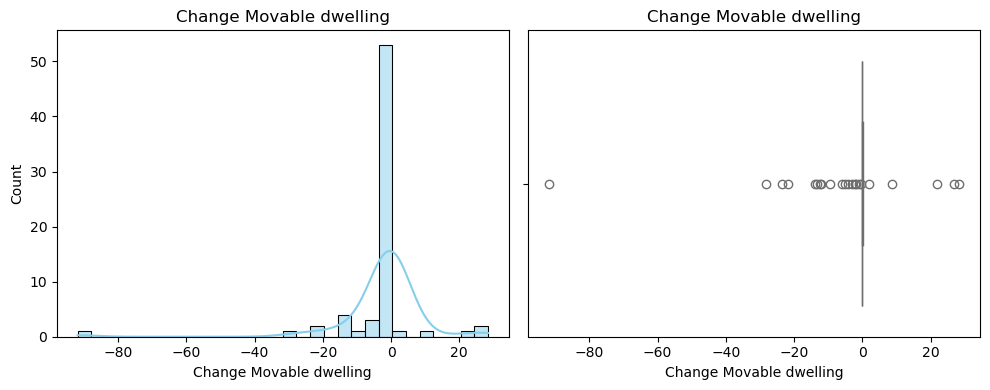

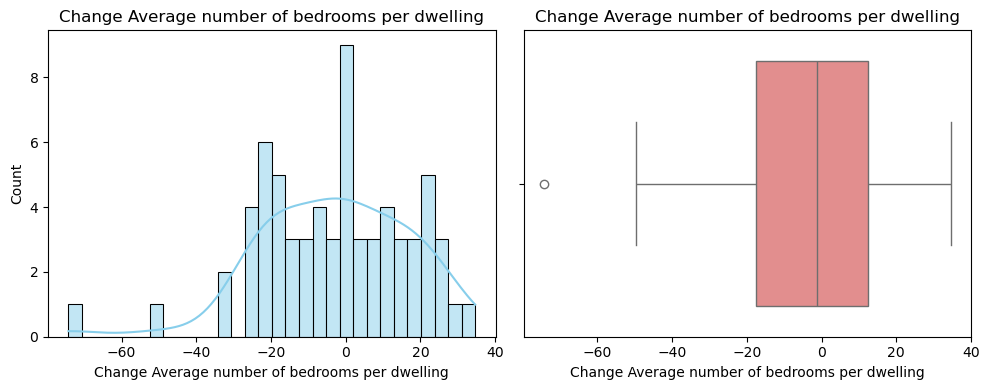

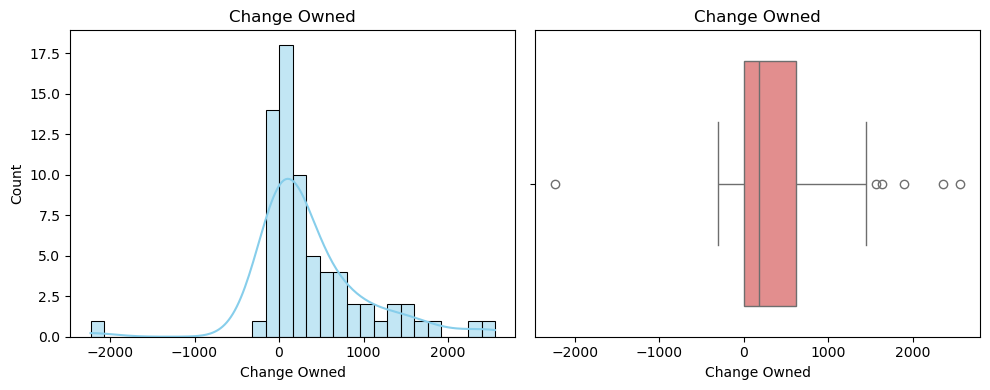

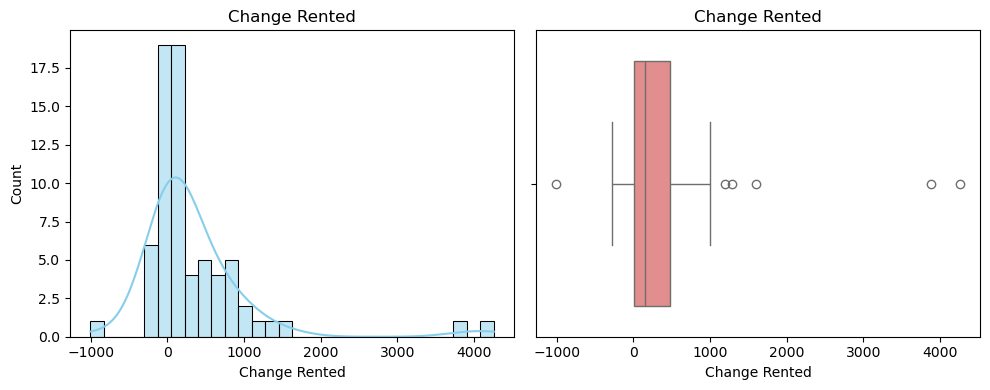

In [29]:
for col in change_df.columns:
    plt.figure(figsize=(10, 4))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(change_df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'{col}')
    plt.xlabel(col)
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=change_df[col], color='lightcoral')
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

<hr style="border:5px solid black">

## Dependent Variables

The 2 dependent variables we are looking at are:
1. $Y_1$ = ```n_movers_out```
2. $Y_2$ = ```n_movers_out_Lowincome```
3. $Y_1'$ = ```%n_movers_out```
4. $Y_2'$ = ```%n_movers_out_Lowincome```

In [30]:
original_population = df["n_movers_out"] + df["n_stayers"]
original_low_income_population = df["n_movers_out_Lowincome"] + df["n_stayers_Lowincome"]

In [31]:
y1_percent = y1 / original_population
y2_percent = y2 / original_low_income_population

In [32]:
y1_percent.name = "%n_movers_out"
y2_percent.name = "%n_movers_out_Lowincome"

In [33]:
dependent_variables = pd.concat([y1, y2, y1_percent, y2_percent], axis=1)

In [34]:
dependent_variables.describe()

,n_movers_out,n_movers_out_Lowincome,%n_movers_out,%n_movers_out_Lowincome
count,68.000000,68.000000,54.000000,54.000000
mean,53754.044118,17288.161765,0.607632,0.674793
std,41481.434485,14208.638609,0.160230,0.144780
min,8495.000000,2465.000000,0.328788,0.429386
25%,25452.500000,6362.500000,0.465190,0.523738
50%,41452.500000,12812.500000,0.612212,0.712977
75%,67363.750000,23213.750000,0.723530,0.783449
max,206545.000000,63385.000000,0.968148,0.954482


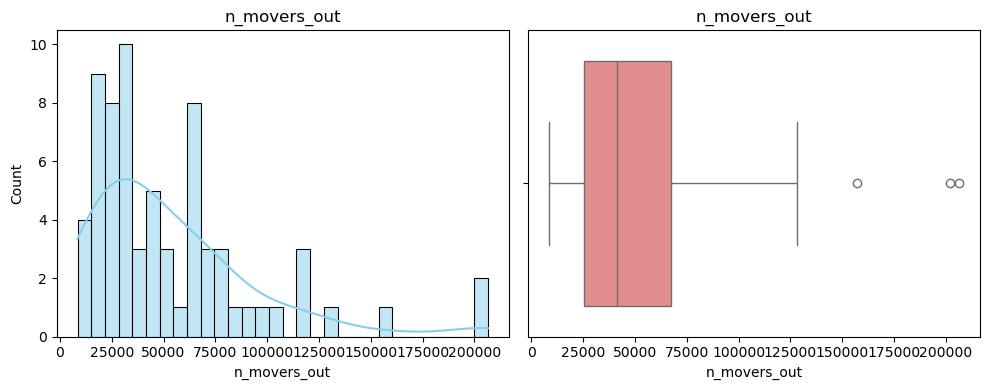

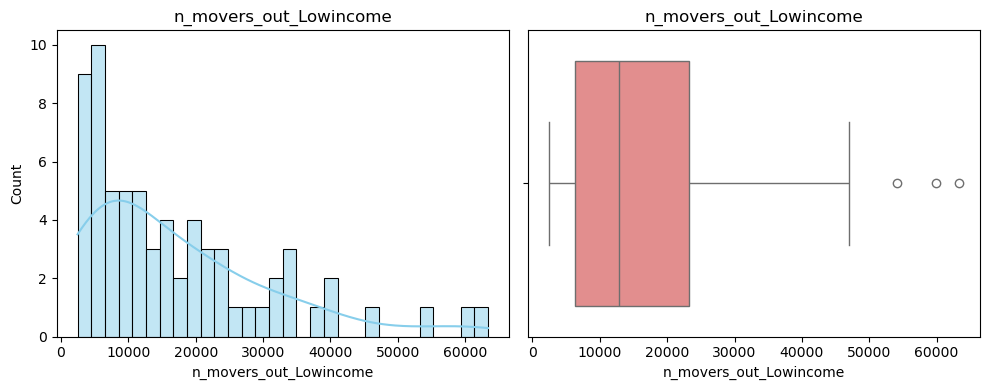

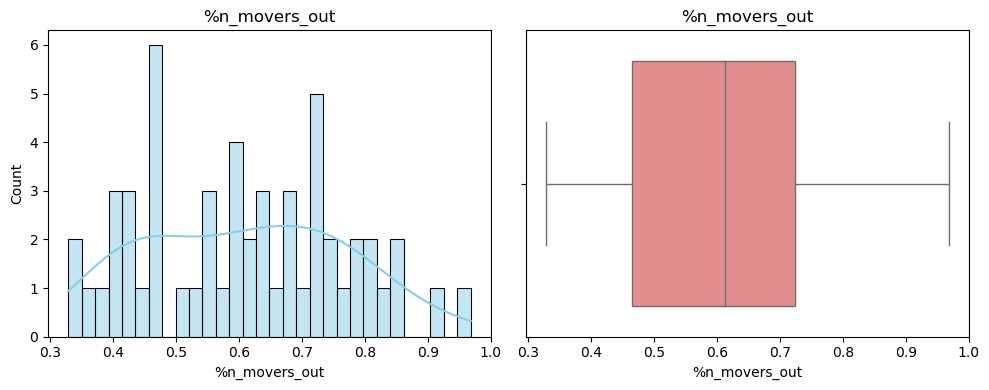

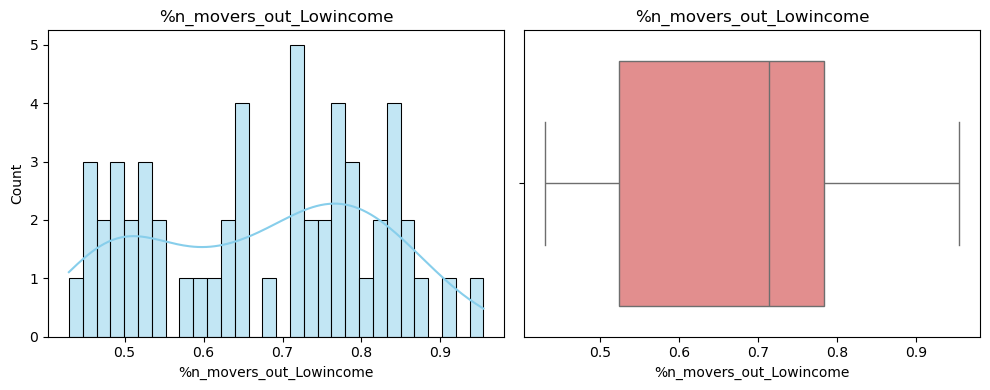

In [35]:
for col in dependent_variables.columns:
    plt.figure(figsize=(10, 4))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(dependent_variables[col], kde=True, bins=30, color='skyblue')
    plt.title(f'{col}')
    plt.xlabel(col)
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=dependent_variables[col], color='lightcoral')
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()